# Predicting Bike Rentals

In many American cities, there are communal bicycle sharing stations where you can rent bicycles by the hour or by the day. Washington, D.C. is one of these cities, and has detailed data available about how many bicycles were rented by hour and by day.

[Hadi Fanaee-T](http://www.liaad.up.pt/area/fanaee) at the [University of Porto](https://sigarra.up.pt/up/pt/web_base.gera_pagina?p_pagina=home) compiled this data into a CSV file, which we'll be working with in this project. The file contains 17380 rows, and each row represents the bike rentals in a single hour of a single day. The data can be downloaded [here](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

This analysis is part of an assigment project at [Dataquest.io](http://www.dataquest.io)

# Objective

In this project, we'll try to predict the total number of bikes rented in a given hour. We'll predict the **```cnt```** column using all the other columns, except **```casual```** and **```registered```**. 

To do this, we'll create a few different machine learning models and evaluate their performance.

In [233]:
# Import required libraries, if you're wondering how to run this file, download and
# install Anaconda (Python 3.5 version) from:
# https://www.continuum.io/downloads
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


# The seaborn library adds great visual styles to existing matplotlib plots
# and includes some functions for new kinds of graphs. For information on how
# to install, please visit:
# http://seaborn.pydata.org/
import seaborn as sns
from datetime import datetime

# A function to plot a categorical column against another column
def plot_categorical(data, categorical_column, column, 
                     title=None, x_axis_title=None, x_axis_labels=None,
                     y_axis_title=None, fig_label=None, label_position="right"):
    # Label position can only be right or left
    assert label_position == 'right' or label_position == 'left', "Label position must be either 'left' or 'right'"
    
    # Specify a default label
    if fig_label is None:
        fig_label = "Fig x"

    # Specify default x axis label
    if x_axis_title is None:
        x_axis_title = categorical_column
        
    # Specify default y axis label
    if y_axis_title is None:
        y_axis_title = column
        
    # Specify default title
    if title is None:
        title = column + " vs " + categorical_column
        
    
    # A dictionary for the aggregation function
    agg_dict = {}
    agg_dict[column] = np.sum

    categorical_count = data.groupby(categorical_column).agg(agg_dict)

    fig, ax = plt.subplots()
    ax.bar(range(1, categorical_count.shape[0] + 1), categorical_count[column], align="center")
    ax.set_title(title)
    ax.set_xlabel(x_axis_title)
    ax.set_ylabel(y_axis_title)
    ax.set_xlim(0, categorical_count.shape[0] + 1)
    ax.set_xticks(range(1, categorical_count.shape[0] + 1))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    
    if x_axis_labels is not None:
        ax.set_xticklabels(x_axis_labels, rotation='vertical')
    
    label_x_pos = 0.85 #right
    if label_position == 'left':
        label_x_pos = 0.05

    # place a text box in upper left in axes coords
    ax.text(label_x_pos, 0.95, fig_label, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    plt.show()
    
# A function to fit a model with training data and then plot its predictions for holdout data against real values. 
def plot_predictions(model, predictors, X_train, X_test, y_train_true, y_test_true, fig_name="Fig X"):
    model.fit(X_train[predictors], y_train_true)
    y_train_pred = model.predict(X_train[predictors])
    y_test_pred = model.predict(X_test[predictors])

    mse_train = mean_squared_error(y_train_true, y_train_pred)
    mse_test = mean_squared_error(y_test_true, y_test_pred)

    print ("MSE for Seen Data {}, MSE for Unseen Data {}".format(mse_train, mse_test))

    # Scatter plot of actual values vs computed values
    fig, ax = plt.subplots()
    plt.scatter(y_test_true, y_test_pred, c="#4d74ae")
    ax.set_title("Actual values vs predicted values")
    ax.set_xlabel("True count for a given hour")
    ax.set_ylabel("Predicted count for a given hour")

    ax.set_ylim(-200, 1000)
    ax.set_xlim(0, 1200)

    ax.arrow(0,0, 850, 850, head_width=30, head_length=50,  color="orange", width=5)

    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, fig_name, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    # place a text box in upper left in axes coords
    ax.text(0.45, 0.95, "Perfect prediction", transform=ax.transAxes, fontsize=10,
            verticalalignment='top', color="#4d74ae", rotation=36)

    plt.show()

In [234]:
# Load the data frame from the CSV file and display summary statistics
bike_rentals = pd.read_csv("hour.csv")
bike_rentals.dteday = pd.to_datetime(bike_rentals.dteday)
bike_rentals.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [235]:
# Show the first five rows to examine columns
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


# Exploratory Data analysis

To understand various facets of the data, we plot some columns against each other and also examine correlation.

Let us look at the time series first:

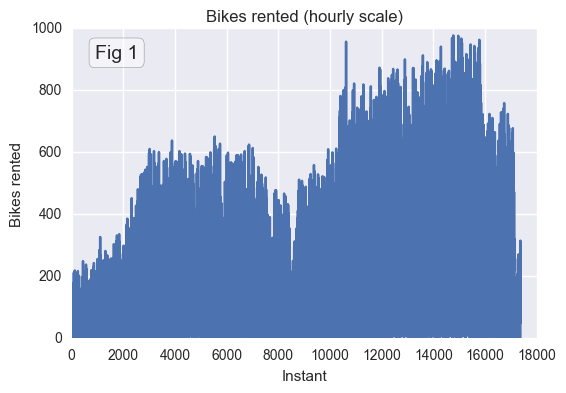

In [236]:
fig, ax = plt.subplots()
ax.plot(bike_rentals["cnt"])
ax.set_title("Bikes rented (hourly scale)")
ax.set_xlabel("Instant")
ax.set_ylabel("Bikes rented")

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper right in axes coords
ax.text(0.05, 0.95, "Fig 1", transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.show()

Let's look at the frequency distribution of the **```cnt```** column:

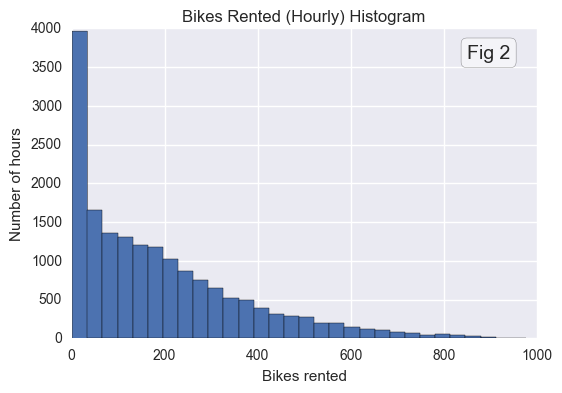

In [237]:
# Plot a histogram of hourly frequencies
ax = bike_rentals["cnt"].hist(bins=30)
ax.set_title("Bikes Rented (Hourly) Histogram")
ax.set_xlabel("Bikes rented")
ax.set_ylabel("Number of hours")

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper right in axes coords
ax.text(0.85, 0.95, "Fig 2", transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.show()

We see this is a long tail distribution. The hours when fewer bikes were rented are more frequent than the hours that more bikes were rented.

Let us look at what are the most popular hours for bike rentals:

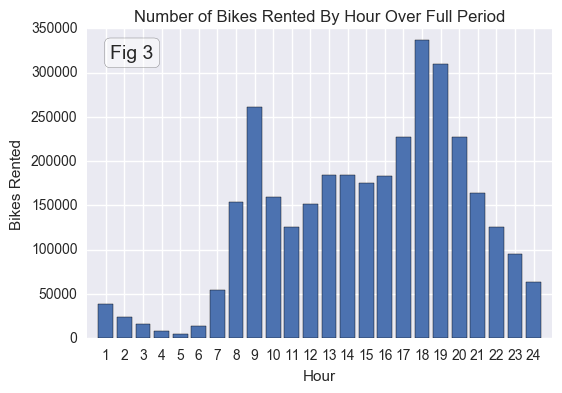

In [238]:
# Examining hour (categorical)
plot_categorical(bike_rentals, "hr", "cnt", 
                 title="Number of Bikes Rented By Hour Over Full Period",
                 x_axis_title="Hour",
                 y_axis_title="Bikes Rented",
                 fig_label="Fig 3",
                 label_position='left'
                )

We see that the distribution has twin peaks. Most bikes were rented in the morning or in the evening.

Next, let us look the common days that bikes were rented on:

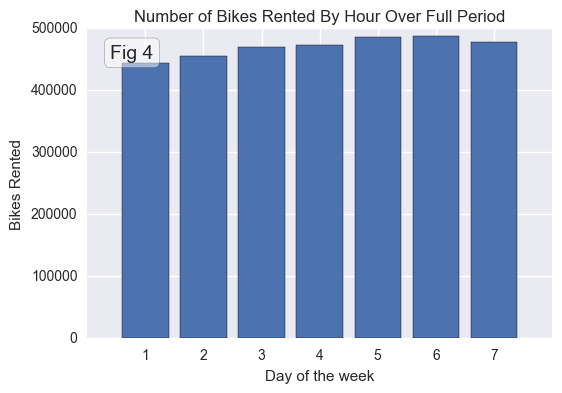

In [239]:
# Examining day of the week (categorical)
plot_categorical(bike_rentals, "weekday", "cnt", 
                 title="Number of Bikes Rented By Hour Over Full Period",
                 x_axis_title="Day of the week",
                 y_axis_title="Bikes Rented",
                 fig_label="Fig 4",
                 label_position='left'
                )

Looks like bikes were rented almost equally on all days!

Which seasons were bikes most rented in?

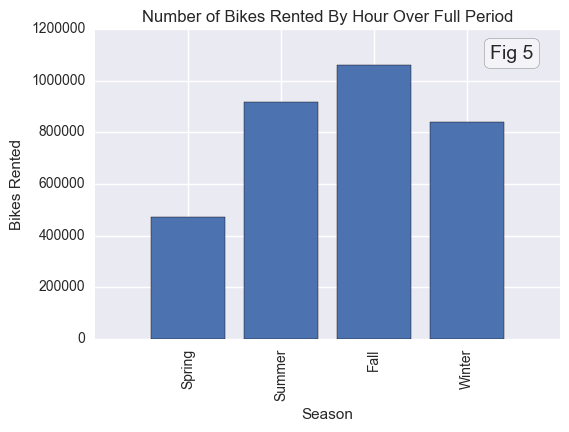

In [240]:
# Examining season (categorical)
plot_categorical(bike_rentals, "season", "cnt", 
                 title="Number of Bikes Rented By Hour Over Full Period",
                 x_axis_title="Season",
                 y_axis_title="Bikes Rented",
                 fig_label="Fig 5",
                 label_position='right',
                 x_axis_labels=["Spring", "Summer", "Fall", "Winter"]
                )

Season definitely has an effect on bike rentals (we shall examine correlation quantitatively later on).

Which months were bikes most rented in?

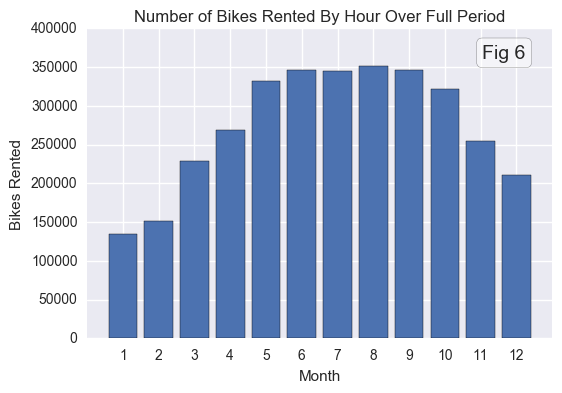

In [241]:
# Examining month (categorical)
plot_categorical(bike_rentals, "mnth", "cnt", 
                 title="Number of Bikes Rented By Hour Over Full Period",
                 x_axis_title="Month",
                 y_axis_title="Bikes Rented",
                 fig_label="Fig 6",
                 label_position='right'
                )

Not surprisingly, we see the maximum number of rentals around summer and fall.

What about the weather situation?

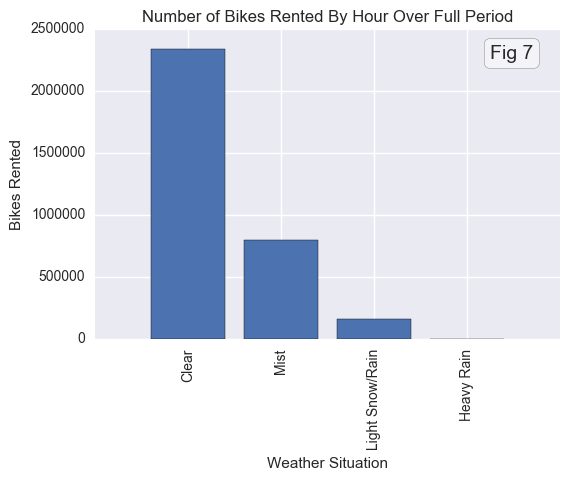

In [242]:
# Examining weather situation (categorical)
plot_categorical(bike_rentals, "weathersit", "cnt", 
                 title="Number of Bikes Rented By Hour Over Full Period",
                 x_axis_title="Weather Situation",
                 y_axis_title="Bikes Rented",
                 fig_label="Fig 7",
                 x_axis_labels=["Clear", "Mist", "Light Snow/Rain", "Heavy Rain"],
                 label_position='right'
                )

Obviously people like to cycle in good weather.

Now let us look at correlation quantitatively.

In [243]:
# First let's examine the columns in the dataset
columns = list(bike_rentals.columns)
columns

['instant',
 'dteday',
 'season',
 'yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'casual',
 'registered',
 'cnt']

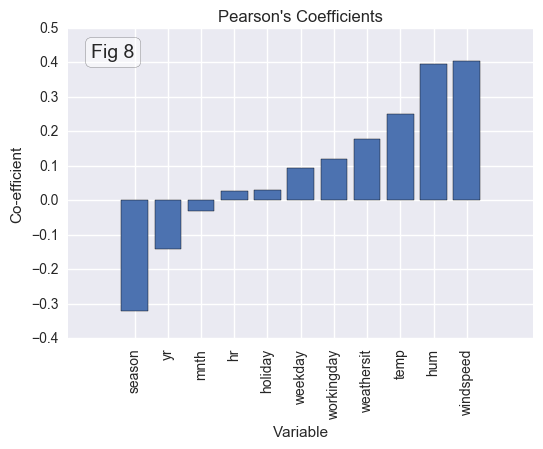

In [244]:
# We ignore certain columns that would not be so relevant while looking
# at correlations. cnt = casual + registered, and atemp is closely related
# to temp.
ignore_columns = ['instant', 'dteday', 'casual', 'registered', 'atemp']
predictors = [c for c in columns if c not in ignore_columns]
corr = bike_rentals[predictors].corr()["cnt"]
del corr["cnt"]
corr = corr.sort_values()
fig, ax = plt.subplots()
xvals = range(0, len(corr))
ax.bar(xvals, corr.values, align="center")
ax.set_xticks(xvals)
ax.set_xticklabels(predictors, rotation='vertical')

ax.set_title("Pearson's Coefficients")
ax.set_xlabel("Variable")
ax.set_ylabel("Co-efficient")

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, "Fig 8", transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.show()

We see that **```windspeed```**, **```hum```** (humidity), **```temp```** (temperature) and **```season```** are the most correlated variables.

# Feature Engineering

It can often be helpful to calculate features before applying machine learning models. Features can enhance the accuracy of models by introducing new information, or distilling existing information.

For example, the **```hr```** column in **```bike_rentals```** contains hours that bikes are rented, from 1 to 24. A machine will treat each hour differently, and not understand that certain hours are related. We can introduce some order into this by creating a new column with labels for morning, afternoon, evening, and night. This will bundle up similar times together, and enable the model to make better decisions.

In [245]:
# Let's create a dictionary for times of day expressed as a starting hour and an ending hour
# From Figure 2, we can partition the day (in terms of hours):

def assign_label(hour):
    '''
        Given an hour returns a label 
    '''
    # The dictionary below defines our partitions:
    # Each key is mapped to a tuple with (starting_hour, ending_hour, category_label)
    times_of_day = {
        "dawn": (5, 8, 1),
        "morning": (9, 12, 2),
        "afternoon": (13, 16, 3),
        "evening": (17, 20, 4),
        "late": (21, 23, 5),
        "night": (0, 4, 6)
    }
    
    for key in times_of_day:
        start, end, label = times_of_day[key]
        if hour >= start and hour <= end:
            return label
    return 0

# Create a new column for our labels
bike_rentals["time_label"] = bike_rentals.hr.apply(assign_label)
predictors.append("time_label")
predictors.remove("cnt")
bike_rentals.head(10)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16,6
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40,6
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32,6
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13,6
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1,6
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2,1
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3,1
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8,1
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14,2


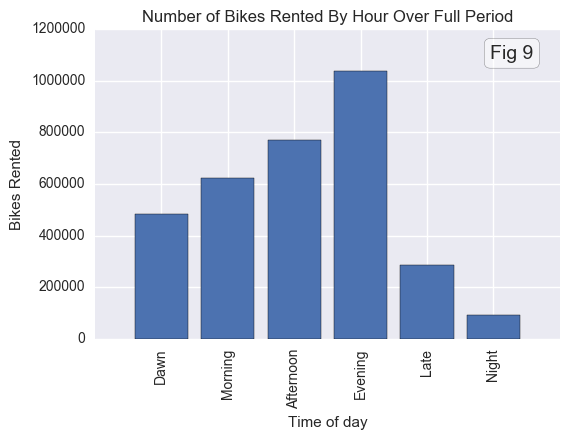

In [246]:
# Examining our new feature
plot_categorical(bike_rentals, "time_label", "cnt", 
                 title="Number of Bikes Rented By Hour Over Full Period",
                 x_axis_title="Time of day",
                 y_axis_title="Bikes Rented",
                 fig_label="Fig 9",
                 x_axis_labels=["Dawn", "Morning", "Afternoon", "Evening", "Late", "Night"],
                 label_position='right'
                )

# Error Metric

Since we are trying to predict the total number of bikes that will be rented in a particular hour, Mean Square Error would be a good metric to understand how far our predicted values are from the real values.

# Holdout

While we will use k-fold cross-validation for our metrics, it is still useful to use a holdout strategy to see prediction accuracy on seen and unseen data.

For this purpose, we split the data into test and train sets.

In [247]:
X_train = bike_rentals.sample(frac=0.8, random_state=3)
X_test = bike_rentals[~bike_rentals.instant.isin(X_train["instant"])]
y_train_true = X_train["cnt"]
y_test_true = X_test["cnt"]

# Models

Given our Exploratory Data Analysis, we can try **`Linear Regression`**, **`Decision Tree Regression`** and **`Random Forest Regression`** on the data set.

## Linear Regression

In [248]:
# Fitting a linear model
lr = LinearRegression()
# Test model with 10 fold cross-validation
kf = KFold(bike_rentals.shape[0], 10, shuffle=True, random_state=8)
mse = cross_val_score(lr, 
                     bike_rentals[predictors], 
                     bike_rentals["cnt"], 
                     scoring="mean_squared_error", 
                     cv=kf)
np.mean(abs(mse))

18216.335440915405

Let us examine the predictions visually by comparing predicted values with actual values:

MSE for Seen Data 18278.54324290182, MSE for Unseen Data 17866.709968141025


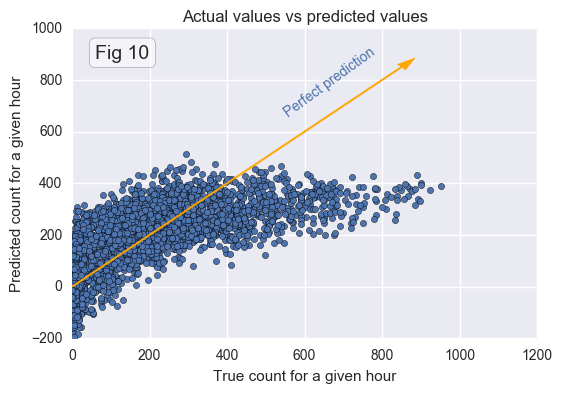

In [249]:
lr = LinearRegression()
plot_predictions(lr, predictors, X_train, X_test, y_train_true, y_test_true, fig_name="Fig 10")

The graph shows that the predictions from the regression are more accurate as long a they are predicting 300 or less. Beyond that value, the predictions deviate significantly from the true value and the regressor will predict values lower than their true values.

## Decision Tree Regression



In [250]:
# Fitting a decision tree
dt = DecisionTreeRegressor()
# Test model with 10 fold cross-validation
kf = KFold(bike_rentals.shape[0], 10, shuffle=True, random_state=8)
mse = cross_val_score(dt, 
                     bike_rentals[predictors], 
                     bike_rentals["cnt"], 
                     scoring="mean_squared_error", 
                     cv=kf)
np.mean(abs(mse))

3472.507432352978

The results are **much** better than Linear Regression.

Let us examine them visually and judge the result on the holdout test data as well.

MSE for Seen Data 0.1883766093648853, MSE for Unseen Data 3401.4474971231302


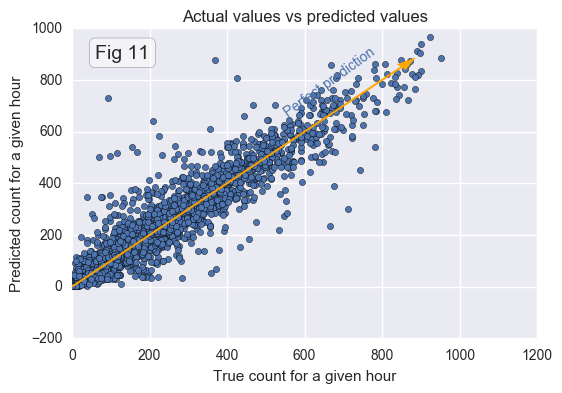

In [251]:
dt = DecisionTreeRegressor()
plot_predictions(dt, predictors, X_train, X_test, y_train_true, y_test_true, fig_name="Fig 11")

From the graph and MSE values for seen and unseen data, we can see that the model is overfitting (MSE for training data is 0.18 while MSE for test data is 3387). 

Below we adjust some parameters to see if we can get better results:

MSE for Seen Data 1735.6898321142937, MSE for Unseen Data 3181.700614241649


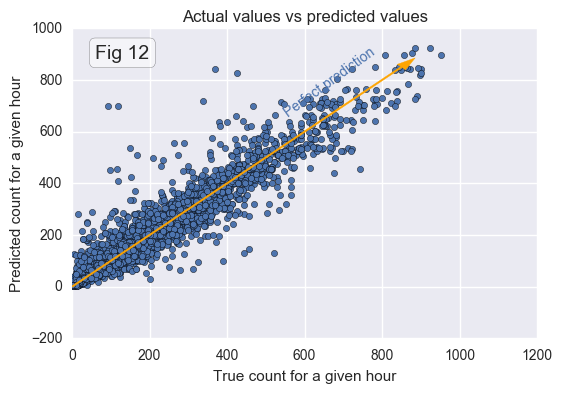

In [252]:
dt = DecisionTreeRegressor(min_samples_leaf=5, random_state=1, splitter="random")
plot_predictions(dt, predictors, X_train, X_test, y_train_true, y_test_true, fig_name="Fig 12")

# Random Forest Regression

Let us see if we can solve the problems of over fitting by using a Random Forest Regressor:

In [253]:
# Fitting a decision tree
rf = RandomForestRegressor(random_state=8)
# Test model with 10 fold cross-validation
kf = KFold(bike_rentals.shape[0], 10, shuffle=True, random_state=8)
mse = cross_val_score(rf, 
                     bike_rentals[predictors], 
                     bike_rentals["cnt"], 
                     scoring="mean_squared_error", 
                     cv=kf)
np.mean(abs(mse))

1983.8394428371896

The results are even better! Let's check on the holdout data:

MSE for Seen Data 1158.565298677894, MSE for Unseen Data 2126.7665223728577


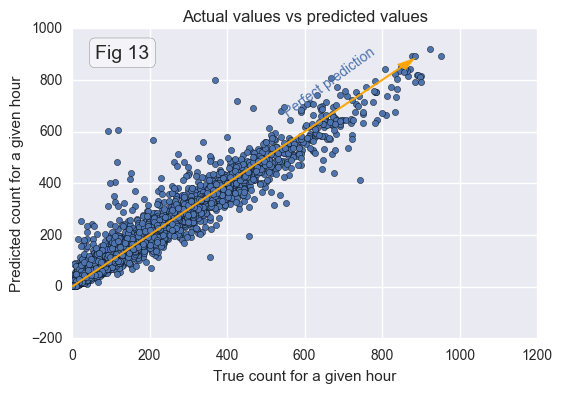

In [254]:
rf = RandomForestRegressor(min_samples_leaf=5, random_state=1, n_estimators=50)
plot_predictions(rf, predictors, X_train, X_test, y_train_true, y_test_true, fig_name="Fig 13")

# Prediction Visualisation

One more useful visualization could be to see the full time series, actual vs predicted:

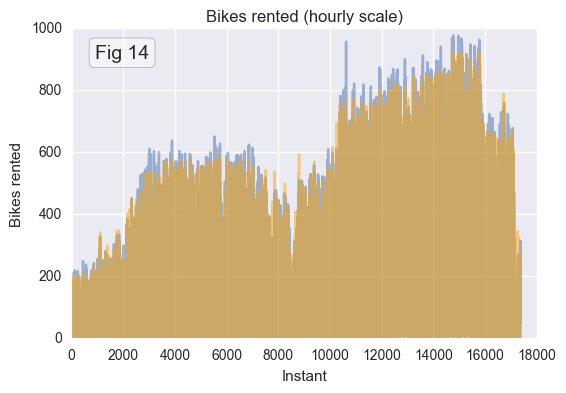

In [255]:
all_pred = rf.predict(bike_rentals[predictors])

fig, ax = plt.subplots()
ax.plot(bike_rentals["cnt"], alpha=0.5)
ax.set_title("Bikes rented (hourly scale)")
ax.set_xlabel("Instant")
ax.set_ylabel("Bikes rented")

ax.plot(all_pred, c="orange", alpha=0.5)

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper right in axes coords
ax.text(0.05, 0.95, "Fig 14", transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.show()

# Conclusion

In this project:

- We have explored predicting a real value based on a set of predictor variables.

- We used basic Linear Regression to obtain a model with a high error value.

- The error value decreased when we used Decision Trees but the Decision Trees were overfitting to our data (significantly lower MSE for seen data vs unseen data)

- We changed the parameters of Decision Trees to obtain better balance of MSE between seen and unseen data.

- Finally, we used Random Forest Regression to obtain the best results.


This is just a learning project. Feedback/criticism/suggestions are welcome.